In [ ]:
import numpy as np
import pickle

path='/home/maria/Documents/HuggingMouseData/MouseViTEmbeddings/google_vit-base-patch16-224_embeddings_logits.pkl'

In [20]:
import numpy as np
import pickle
from scipy.special import softmax
import matplotlib.pyplot as plt

# Path to your ViT embeddings
path = '/home/maria/Documents/HuggingMouseData/MouseViTEmbeddings/google_vit-base-patch16-224_embeddings_logits.pkl'
#path='/home/maria/Documents/HuggingMouseData/CIFARLogits/cifar100_resnet56_embeddings_logits.pkl'
#path='/home/maria/Documents/HuggingMouseData/CIFARLogits/cifar10_resnet56_embeddings_logits.pkl'
# Load
with open(path, 'rb') as f:
    vit_dict = pickle.load(f)['natural_scenes']

# Convert to a matrix
# If vit_dict is {image_id: logits_vector}
embeddings = np.stack(list(vit_dict))  # shape: (N_images, n_classes)
print("Embeddings shape:", embeddings.shape)

# Compute softmax over classes
softmax_embeddings = softmax(embeddings, axis=1)


Embeddings shape: (118, 1000)


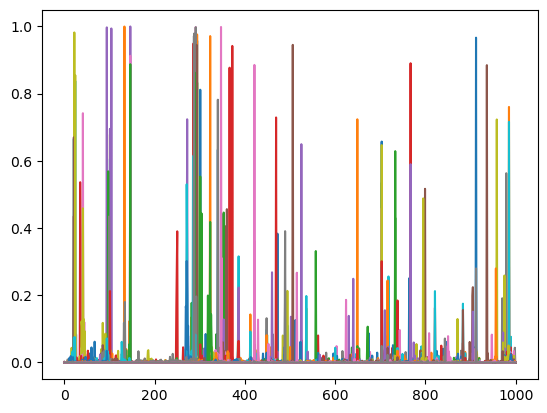

In [21]:
plt.plot(softmax_embeddings.T)

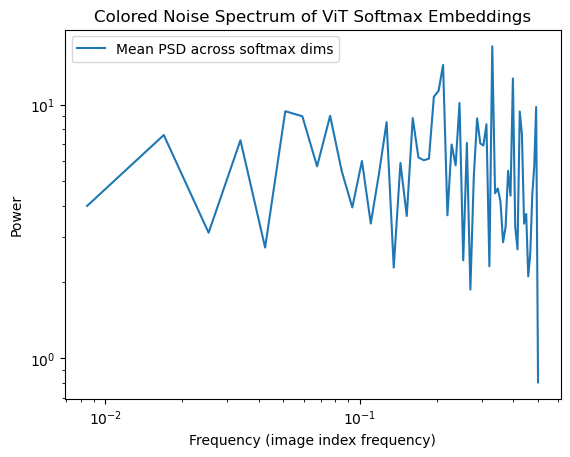

In [12]:
# Compute PSD for each class probability across the image index
N, C = softmax_embeddings.shape
freqs = np.fft.rfftfreq(N)
psd = np.abs(np.fft.rfft(softmax_embeddings - softmax_embeddings.mean(axis=0), axis=0))**2

# Average PSD over all classes
mean_psd = psd.mean(axis=1)

plt.loglog(freqs[1:], mean_psd[1:], label='Mean PSD across softmax dims')
plt.xlabel('Frequency (image index frequency)')
plt.ylabel('Power')
plt.title('Colored Noise Spectrum of ViT Softmax Embeddings')
plt.legend()
plt.show()


In [14]:
print(mean_psd.shape)

(60,)


In [13]:
# Fit spectral exponent
log_f = np.log(freqs[1:])
log_p = np.log(mean_psd[1:])
alpha, intercept = np.polyfit(log_f, log_p, 1)

print(f"Spectral exponent α ≈ {-alpha:.2f}")

Spectral exponent α ≈ 0.07
